In [83]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm_notebook, tqdm # for문 얼마나 반복하였는지 확인 가능

## Data 준비

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 우리가 분류할 20개의 클래스 + 5개

CLASSES = [ 'airplane', 'bird', 'boat', 'bottle', 'car','cat', 'dog', 'drone', 'hamburger', 'horse', 'logo', 'minions', 'paper', 'person', 'rock', 'scissors', 'train']

In [ ]:
class2idx = {cls:idx for idx, cls in enumerate(CLASSES)}
class2idx

{'airplane': 0,
 'bird': 1,
 'boat': 2,
 'bottle': 3,
 'car': 4,
 'cat': 5,
 'dog': 6,
 'drone': 7,
 'hamburger': 8,
 'horse': 9,
 'logo': 10,
 'minions': 11,
 'paper': 12,
 'person': 13,
 'rock': 14,
 'scissors': 15,
 'train': 16}

In [98]:
## directory 설정
IMAGE_BASE_PATH = './drive/My Drive/data/'
train_path = IMAGE_BASE_PATH + 'train/'
valid_path = IMAGE_BASE_PATH + 'valid/'
# test_path = IMAGE_BASE_PATH + 'test/'

In [100]:
## image file 수 확인
train_image_files = glob(train_path + '*/*')
valid_image_files = glob(valid_path + '*/*')
# test_image_files = glob(test_path + '*/*.jpg')
print(len(valid_image_files))

510


In [ ]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_path in train_image_files:
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_path, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

for image_path in valid_image_files:
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_path, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

train_image_files = glob(train_path + '*/*.jpg')
valid_image_files = glob(valid_path + '*/*.jpg')
# test_image_files = glob(test_path + '*/*.jpg')

./drive/My Drive/data/train/scissors/testscissors04-30.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-26.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-25.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-20.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-10.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-09.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-07.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-00.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-16.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors04-12.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors03-29.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors03-16.png RGBA
(300, 300, 4)
./drive/My Drive/data/train/scissors/testscissors03-13.png RGBA


KeyboardInterrupt: ignored

## TFRecord File 만들기

In [101]:
IMG_SIZE = 224

In [102]:
## TFRecord 저장할 directory와 file 경로 설정
data_dir = IMAGE_BASE_PATH

tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [103]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [104]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [105]:
n_train = 0

train_files = train_image_files
for train_path in tqdm_notebook(train_files):
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = train_path.split('/')[5] #Bangal_101
  class_num = class2idx[file_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



1530


In [106]:
n_val = 0

val_files = valid_image_files
for val_path in tqdm_notebook(val_files):
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = val_path.split('/')[5] #Bangal_101
  class_num = class2idx[file_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print(n_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



510


## Classification

In [107]:
## Hyper Parameters
N_CLASS = len(CLASSES)
N_EPOCHS = 50
N_BATCH = 30
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN // N_BATCH
validation_steps = N_VAL // N_BATCH

In [108]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)

    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    label = tf.one_hot(label, N_CLASS)

    return image, label

In [109]:
## CutMix
def cutmix(images, labels, PROB=0.5):  
  imgs = []; labs = []
  for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) <= PROB, tf.int32)
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

    W = IMG_SIZE; H = IMG_SIZE
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)    
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)    
    
    mid_left = images[i, ymin:ymax, :xmin, :]
    mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_img)
    
    alpha = tf.cast((cut_w*cut_h)/(W*H), tf.float32)
    label1 = labels[i]; label2 = labels[idx]
    new_label = ((1-alpha)*label1 + alpha*label2)
    labs.append(new_label)

  new_imgs = tf.reshape(tf.stack(imgs), [-1, IMG_SIZE, IMG_SIZE, 3])
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

  return new_imgs, new_labs

In [110]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH)
train_dataset = train_dataset.map(cutmix).repeat()

In [111]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [112]:
for image, label in train_dataset.take(1):
  for i in range(N_BATCH):    
    print(label[i].numpy())
    plt.imshow(image[i])
    plt.show()

InvalidArgumentError: ignored

In [113]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Conv2D,GlobalAveragePooling2D

In [114]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

# transfer learning에서 마지막 3개 block 을 사용하여 모델을 트레이닝 합니다. 

set_trainable = False
for layer in tqdm(base_model.layers):
    if layer.name in ['block_14_expand','block_15_expand', 'block_16_expand']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

100%|██████████| 155/155 [00:00<00:00, 30204.29it/s]


In [ ]:
# 모델 만들기, 기존 모델의 weight 값을 사용하고 pooling 과 activation 함수를 추가 합니다. 

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512,activation='relu'),
    Dense(64,activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])

model.summary()

In [ ]:
## compile & summary

LR_INIT = 0.00001
LR_MAX = 0.0003
LR_MIN = LR_INIT
RAMPUP_EPOCH = 10
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
  if epoch < RAMPUP_EPOCH:
    lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
  else:
    lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
  return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [ ]:
def plot_lr():
  lr = []
  epoch_list = list(np.arange(N_EPOCHS) + 1)
  for epoch in range(N_EPOCHS):
    lr.append(lr_schedule_fn(epoch))    
  plt.plot(epoch_list, lr, 'b-')
  plt.xlabel('Epoch')
  plt.show()

plot_lr()

In [ ]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

In [ ]:
model.save('./drive/My Drive/bin/MobileNetV2_cutmix_warmup_class25.h5')

In [ ]:
# 추론하기 위한 작업입니다. 모델 설정, 입력 데이터 전처리.
import cv2
import pickle

def predict_test_img(path):
    img = cv2.imread(path) 
    
    model = load_model('./drive/My Drive/bin/MobileNetV2_cutmix_warmup_class25.h5')
    
    print('Original Shape : ',img.shape)
    
    img = cv2.resize(img, (224,224), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    print('Resized Shape : ',img.shape)
    plt.imshow(img)
    plt.show()
    
    ans = model.predict_classes(np.expand_dims(img,axis=0))
    with open('./drive/My Drive/bin/class20.pickle','rb') as f:
        class20 = pickle.load(f)
    print('Predict : {}'.format(class20[ans[0]]))
    
    
    predicted_result = model.predict(np.expand_dims(img,axis=0))

    pd.DataFrame(predicted_result,columns=class20.values()).iloc[0].plot(kind='bar')
    plt.show()

Original Shape :  (500, 500, 3)
Resized Shape :  (224, 224, 3)


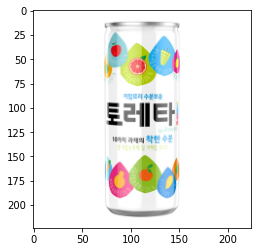

Predict : bottle


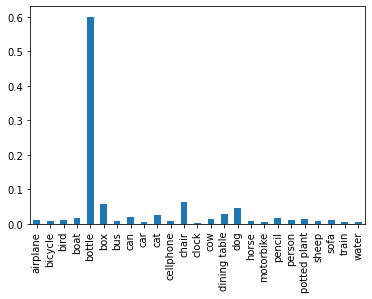

In [ ]:
# 기존에 사용되지 않았던 임의 데이터를 추론 하기

predict_test_img('./drive/My Drive/img/can.jpg')

Original Shape :  (224, 224, 3)
Resized Shape :  (224, 224, 3)


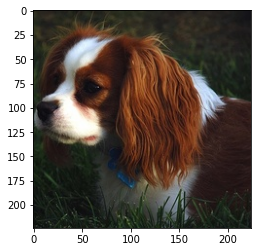

Predict : cat


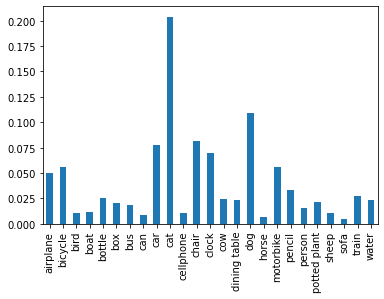

In [ ]:
predict_test_img('./drive/My Drive/img/dog.jpg')

Original Shape :  (350, 350, 3)
Resized Shape :  (224, 224, 3)


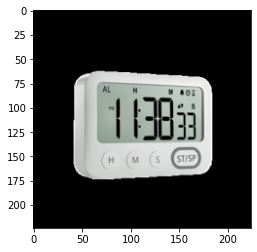

Predict : can


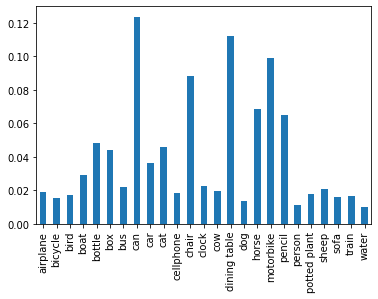

In [ ]:
predict_test_img('./drive/My Drive/img/clock.jpg')